In [90]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation


In [2]:
# UTILS FOR PLOTTING

def plot_velocity_field(grid_X, grid_Y, velocity_field_u, velocity_field_v, title = "Velocity Field"):
    # plt.quiver(grid_X, grid_Y, velocity_field_u, velocity_field_v, scale=20)
    plt.streamplot(grid_X, grid_Y, velocity_field_u, velocity_field_v)
    plt.title(title)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

def plot_pressure_field(grid_X, grid_Y, pressure_field, title = "Pressure Field"):
    plt.pcolormesh(grid_X, grid_Y, pressure_field, cmap="viridis", shading="auto")
    plt.colorbar(label="Pressure")
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [3]:
# UTILS FOR CALCULATIONS REGARDING FLOW FIELDS

def get_divergence_of_cell(i, j, u, v): # returns float
    # should be able to consider when i and j are at the borders of the grid
    d = u[i+1][j]-u[i][j] + v[i][j+1] - v[i][j]
    return d

def get_s_sum_value_of_cell(i, j, s_field):
    s = s_field[i+1][j] + s_field[i-1][j] + s_field[i][j+1] + s_field[i][j-1]
    return s

In [157]:
class FluidSimulation:
    def __init__(self,nx,ny, dt = 0.1, num_iterations = 10, rho = 100, overrelaxation = 1.5):
        self.dy = 1
        self.dx = 1 
        self.g = -9.81
        self.overrelaxation = overrelaxation
        self.h = self.dx
        self.dt = dt
        self.num_iterations = num_iterations
        self.rho = rho # density
        self.nx = nx+2
        self.ny = ny+2
        self.num_cells = self.nx*self.ny
        
        x = np.arange(0, (nx+2) * dx, dx) # +2 for boundary conditions,
        y = np.arange(0, (ny+2) * dy, dy)
        grid_X, grid_Y = np.meshgrid(x, y) # staggered grid
        self.grid_X = grid_X
        self.grid_Y = grid_Y

        # FIELDS
        self.u = np.zeros_like(grid_X)
        self.v = np.zeros_like(grid_Y)
        self.p = np.zeros_like(grid_X)
        self.s = np.ones_like(grid_X) 
        self.s[:, 0] = 0  # Set the left boundary to zero
        self.s[:, -1] = 0  # Set the right boundary to zero
        # self.s[0, :] = 0  # Set the top boundary to zero
        self.s[-1, :] = 0  # Set the bottom boundary to zero
        self.m = np.ones_like(grid_X)

    def integrate(self):
        for i in range(1, self.nx):
            for j in range(1, self.ny):
                if self.s[i][j] != 0 and self.s[i][j-1] != 0:
                    self.v[i][j] += self.dt*self.g

    def solve_incompressibility(self):
        cp = rho*h/dt
        for _ in range(self.num_iterations):
            for i in range(1, self.nx-1):
                for j in range(1, self.ny-1): 
                    
                    if self.s[i][j] == 0: # wall
                        continue
        
                    s = self.s[i][j]
                    sx0 = self.s[i-1][j] 
                    sx1 = self.s[i+1][j] 
                    sy0 = self.s[i][j-1] 
                    sy1 = self.s[i][j+1]
                    s = sx0 + sx1 + sy0 + sy1
        
                    if s == 0:
                        continue
                        
                    div = self.u[i+1][j]-self.u[i][j] + self.v[i][j+1] - self.v[i][j]
                    
                    p = -div/s
                    p *= self.overrelaxation # over-relaxation
                    
                    self.p[i][j] += cp * p  # not necessary for simulation   
        
                    # p /= o
                    self.u[i][j] -=  sx0 * p
                    self.u[i+1][j] += sx1 * p 
                    self.v[i][j] -= sy0 * p
                    self.v[i][j+1] += sy1 * p 

    def extrapolate(self):
        for i in range(0, self.nx):
            self.u[i][0] = self.u[i][1]
            self.u[i][ny-1] = self.u[i][ny-2]
            
        for j in range(0, self.ny):
            self.v[0][j] = self.v[1][j]
            self.v[nx+1][j] = self.v[nx][j] 

    def sample_field(self,x, y, field):
        h = self.h
        nx = self.nx
        ny = self.ny
        
        h1 = 1 / h
        h2 = 0.5 * h
        x = max(min(x,x*h),h)
        y = max(min(y,y*h),h)
        dx = dy = 0
    
        if field == "U_FIELD":
            f = self.u
            dy = h2
        elif field == "V_FIELD":
            f = self.v
            dx = h2
        elif field == "S_FIELD":
            f = self.m
            dx = h2
            dy = h2
    
        x0 = min(np.floor((x-dx)*h1), nx-1)
        tx = ((x-dx)-x0*h)*h1
        x1 = min(x0+1,nx-1)
    
        y0 = min(np.floor((y-dy)*h1), ny-1)
        ty = ((y-dy)-y0*h)*h1
        y1 = min(y0+1,ny-1)
    
        sx = 1-tx
        sy = 1-ty
    
        x0 = int(x0)
        x1 = int(x1)
        y0 = int(y0)
        y1 = int(y1)
        val = (sx * sy * f[x0][y0] +
           tx * sy * f[x1][y0] +
           tx * ty * f[x1][y1] +
           sx * ty * f[x0][y1])
    
        return val

        
    def avg_u(self, i,j):
        u = (self.u[i][j-1] + self.u[i][j] +
             self.u[i+1][j-1] + self.u[i+1][j]) * 0.25
        return u

    def avg_v(self, i,j):
        v = (self.v[i][j-1] + self.v[i][j] +
             self.v[i+1][j-1] + self.v[i+1][j]) * 0.25
        return v


    def advect_vel(self):
        self.new_u = self.u.copy()
        self.new_v = self.v.copy()
        h = self.h
        h2 = 0.5 * h
        for i in range(1,self.nx):
            for j in range(1,self.ny):
                
                # u component
                if (self.s[i][j]!=0 and self.s[i-1][j]!=0 and j<self.ny-1):
                    x = i*h
                    y = j*h+h2
                    u = self.u[i][j]
                    v = avg_v(i,j) # what do we do with this? nextline overwrites it!!
                    v = sample_field(x,y,"V_FIELD")
                    x = x-dt*u
                    y = y-dt*v
                    u = sample_field(x,y,"U_FIELD")
                    self.new_u[i][j] = u
        
                if (self.s[i][j]!=0 and self.s[i-1][j]!=0 and i<self.nx-1):
                    x = i*h + h2
                    y = j*h
                    u = avg_u(i,j)
                    u = sample_field(x,y,"U_FIELD")
                    v = self.v[i][j]
                    x = x-dt*u
                    y = y-dt*v
                    v = sample_field(x,y,"V_FIELD")
                    velocity_field_v_new[i][j] = v
                    
        self.u = self.new_u
        self.v = self.new_v

    def advect_smoke(self):
        self.new_m = self.m.copy()
        n = self.ny
        h = self.h
        h2 = 0.5*h
        for i in range(1,self.nx-1):
            for j in range(1,self.ny-1):
                if (self.s[i][j]!=0):
                    u = (self.u[i][j] + self.u[i+1][j])*0.5
                    v = (self.v[i][j] + self.v[i+1][j])*0.5
                    x = i*j + h2 - dt*u
                    y = j*h + h2 - dt*v
                    self.new_m[i][j] = self.sample_field(x,y,"S_FIELD")

        self.m = self.new_m

    def simulate(self): # simulates one frame
        self.integrate()
        self.u[10:self.ny-10, 1] = 10 # uniform flow
        self.p = np.zeros_like(self.p)
        self.solve_incompressibility()
        

        self.extrapolate()
        self.advect_vel()
        self.advect_smoke()
        

    def animate_pressure_field(self, interval=50, frames=100):
        fig, ax = plt.subplots()
        im = ax.imshow(self.p, cmap='viridis')
        title = ax.set_title('Frame: 0')

        def update(frame):
            self.simulate()  # Simulate to the next frame
            im.set_array(self.p)
            title.set_text('Frame: {}'.format(frame))
            return im,

        ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
        plt.colorbar(im)
        ani.save("pressure.gif", writer='pillow', fps=10)  # Adjust fps as needed

        plt.show()

    def animate_smoke_particles(self, interval=50, frames=100):
        fig, ax = plt.subplots()
        im = ax.imshow(self.m, cmap='binary')
        title = ax.set_title('Frame: 0')


        def update(frame):
            self.simulate()  # Simulate to the next frame
            im.set_array(self.m)
            title.set_text('Frame: {}'.format(frame))
            return im,

        ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
        plt.colorbar(im)
        ani.save("smoke.gif", writer='pillow', fps=10)  # Adjust fps as needed

        plt.show()

    def animate_streamlines(self, interval=50, frames=100):
        fig, ax = plt.subplots()
        title = ax.set_title('Frame: 0')
        
        def update(frame):
            self.simulate()  # Simulate to the next frame
            ax.clear()
            ax.streamplot(self.grid_X, self.grid_Y, self.u, self.v, color='b')
            title.set_text('Frame: {}'.format(frame))
            return title,

        ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)

        # Save the animation as a GIF
        ani.save("streamline.gif", writer='pillow', fps=10)  # Adjust fps as needed



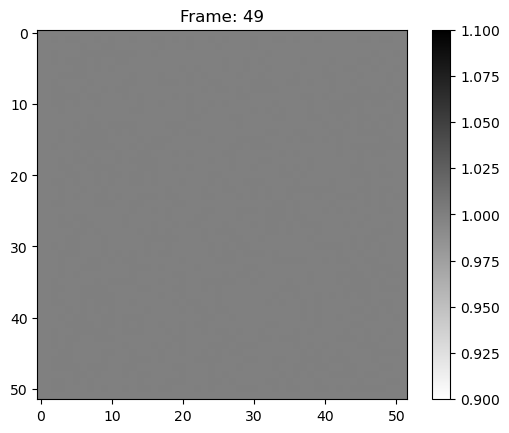

In [158]:
sim = FluidSimulation(50,50,num_iterations=5)

sim.animate_smoke_particles(frames = 50)

In [159]:
for _ in range(30):
    sim.simulate()


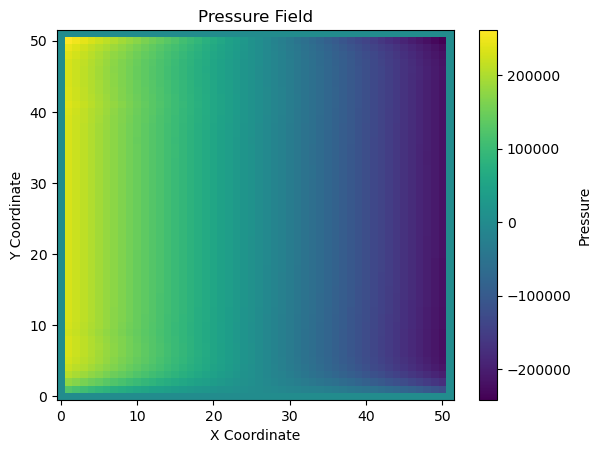

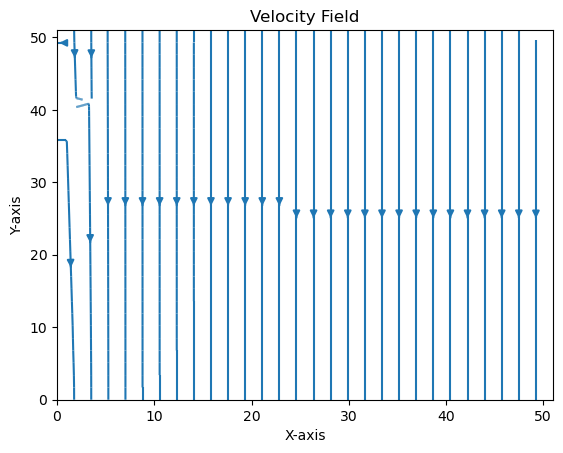

In [160]:
plot_pressure_field(sim.grid_X, sim.grid_Y, sim.p)
plot_velocity_field(sim.grid_X, sim.grid_Y, sim.u,sim.v)

In [38]:
# INIT FIELDS 
# init grid, gravity and rho
nx = ny = 50
dx = dy = 1.0 # works when the spacing is the same
h = dx

# there would be a extra layer in the boundaries, which doesn't change its values, always zero
x = np.arange(0, (nx+2) * dx, dx) # +2 for boundary conditions,
y = np.arange(0, (ny+2) * dy, dy)
grid_X, grid_Y = np.meshgrid(x, y) # staggered grid

g =  -9.81 # in negative y direction (downwards)
rho = 100 # density

# init velocity field:  vel_field_i = (u, v)
velocity_field_u = np.zeros_like(grid_X) 
velocity_field_v = np.zeros_like(grid_Y) 

# init pressure field:  pressure_field_ij = p_ij
pressure_field = np.zeros_like(grid_X)

# init numerical parameters
dt = 0.01
num_iterations = 1

# s field, for obstacles and walls
# s_ij = 0 -> wall, s_ij = 1 -> free space
s_field = np.ones_like(grid_X) 
s_field[:, 0] = 0  # Set the left boundary to zero
s_field[:, -1] = 0  # Set the right boundary to zero
# s_field[0, :] = 0  # Set the top boundary to zero
s_field[-1, :] = 0  # Set the bottom boundary to zero

# # Create a circle in the center
# center_x, center_y = (nx+2) // 2, (ny+2) // 2
# radius = 2 
# # radius = min(nx, ny) // 4  # Adjust the radius as needed
# y, x = np.ogrid[:nx+2, :ny+2]
# mask = (x - center_y)**2 + (y - center_x)**2 <= radius**2
# s_field[mask] = 0  # Set values inside the circle to zero

# overrelaxation constant
o = 1.5

# # velocity_field_v[0][0] += g*dt/2
# plot_velocity_field(grid_X, grid_Y, velocity_field_u, velocity_field_v, title = "initialized velocity field")

# # pressure_field[0][0] = 10
# plot_pressure_field(grid_X, grid_Y, pressure_field)



In [39]:
print(s_field)
print(s_field.shape)

[[0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(52, 52)


In [40]:
## ASSUMPTIONS:
# 1 - incompressible flow
# 2 - steady flow
# 3 - No viscosity: Re -> inf
# https://matthias-research.github.io/pages/tenMinutePhysics/index.html


In [41]:
# integrate
for i in range(1, nx):
    for j in range(1, ny):
        if s_field[i][j] != 0 and s_field[i][j-1] != 0:
            velocity_field_v[i][j] += dt*g

pressure_field = np.zeros_like(grid_X)

# velocity_field_u[:, 1] = 10 # uniform flow

In [43]:
# solveIncompressibility
cp = rho*h/dt
for _ in range(num_iterations):
    for i in range(1, nx-1):
        for j in range(1, ny-1): 
            
            if s_field[i][j] == 0: # wall
                continue

            s = s_field[i][j]
            sx0 = s_field[i-1][j] 
            sx1 = s_field[i+1][j] 
            sy0 = s_field[i][j-1] 
            sy1 = s_field[i][j+1]
            s = sx0 + sx1 + sy0 + sy1

            if s == 0:
                continue
                
            div = get_divergence_of_cell(i, j, velocity_field_u, velocity_field_v) 
            
            p = -div/s
            p *= o # over-relaxation
            
            pressure_field[i][j] += cp * p  # not necessary for simulation   

            # p /= o
            velocity_field_u[i][j] -=  sx0 * p
            velocity_field_u[i+1][j] += sx1 * p 
            velocity_field_v[i][j] -= sy0 * p
            velocity_field_v[i][j+1] += sy1 * p 


In [44]:
# extrapolate?
for i in range(0, nx):
    velocity_field_u[i][0] = velocity_field_u[i][1]
    velocity_field_u[i][ny-1] = velocity_field_u[i][ny-2]
    
for j in range(0, ny):
    velocity_field_v[0][j] = velocity_field_v[1][j]
    velocity_field_v[nx+1][j] = velocity_field_v[nx][j] 



In [49]:
x = 0.3
min(x,x*h)

0.3

In [60]:
## advectVel

# sampleField? kinda like average I guess
def sample_field(x, y, field):
    h1 = 1 / h
    h2 = 0.5 * h
    x = max(min(x,x*h),h)
    y = max(min(y,y*h),h)
    dx = dy = 0

    if field == "U_FIELD":
        f = velocity_field_u
        dy = h2
    elif field == "V_FIELD":
        f = velocity_field_v
        dx = h2
    elif field == "S_FIELD":
        f = s_field
        dx = h2
        dy = h2

    x0 = min(np.floor((x-dx)*h1), nx-1)
    tx = ((x-dx)-x0*h)*h1
    x1 = min(x0+1,nx-1)

    y0 = min(np.floor((y-dy)*h1), ny-1)
    ty = ((y-dy)-y0*h)*h1
    y1 = min(y0+1,ny-1)

    sx = 1-tx
    sy = 1-ty

    x0 = int(x0)
    x1 = int(x1)
    y0 = int(y0)
    y1 = int(y1)
    val = (sx * sy * f[x0][y0] +
       tx * sy * f[x1][y0] +
       tx * ty * f[x1][y1] +
       sx * ty * f[x0][y1])

    return val

def avg_u(i,j):
    u = (velocity_field_u[i][j-1] + velocity_field_u[i][j] +
         velocity_field_u[i+1][j-1] + velocity_field_u[i+1][j]) * 0.25
    return u

def avg_v(i,j):
    v = (velocity_field_v[i][j-1] + velocity_field_v[i][j] +
         velocity_field_v[i+1][j-1] + velocity_field_v[i+1][j]) * 0.25
    return v

# advectVel
velocity_field_u_new = velocity_field_u.copy()
velocity_field_v_new = velocity_field_v.copy()
h = h
h2 = 0.5 * h
for i in range(1,nx):
    for j in range(1,ny):
        
        # u component
        if (s_field[i][j]!=0 and s_field[i-1][j]!=0 and j<ny-1):
            x = i*h
            y = j*h+h2
            u = velocity_field_u[i][j]
            v = avg_v(i,j) # what do we do with this? nextline overwrites it!!
            v = sample_field(x,y,"V_FIELD")
            x = x-dt*u
            y = y-dt*v
            u = sample_field(x,y,"U_FIELD")
            velocity_field_u_new[i][j] = u

        if (s_field[i][j]!=0 and s_field[i-1][j]!=0 and i<nx-1):
            x = i*h + h2
            y = j*h
            u = avg_u(i,j)
            u = sample_field(x,y,"U_FIELD")
            v = velocity_field_v[i][j]
            x = x-dt*u
            y = y-dt*v
            v = sample_field(x,y,"V_FIELD")
            velocity_field_v_new[i][j] = v
            
velocity_field_u = velocity_field_u_new
velocity_field_v = velocity_field_v_new
            

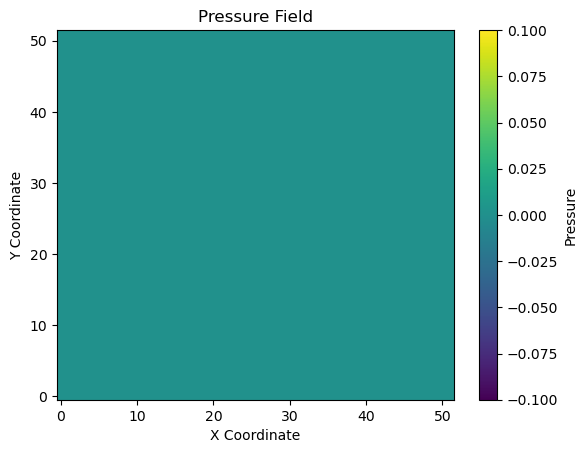

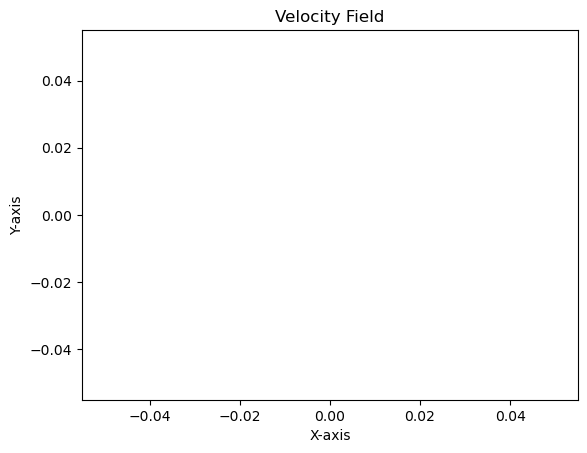

(array([], dtype=int64), array([], dtype=int64))


In [6]:
from fluid import Fluid

density = 1.0
numX = nx
numY = ny
h = 1.0
gravity = -9.81
dt = 0.1
numIters = 10

scene = Fluid(density, numX, numY, h)
for _ in range(1):
    scene.integrate(dt, gravity)
    scene.p = np.zeros_like(grid_X)
    scene.solveIncompressibility(numIters, dt)
    
    scene.extrapolate()
    scene.advectVel(dt)
    scene.advectSmoke(dt)

p_f = np.reshape(scene.p, newshape=(nx+2, ny+2))
u_f = np.reshape(scene.newU, newshape=(nx+2, ny+2))
v_f = np.reshape(scene.newV, newshape=(nx+2, ny+2))

plot_pressure_field(grid_X, grid_Y, p_f)
plot_velocity_field(grid_X, grid_Y, u_f, v_f)
print(np.nonzero(scene.p))